<a href="https://colab.research.google.com/github/gerard08/ProjecteVC/blob/master/provaGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importem les imatges

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unrar
!unrar x /content/drive/MyDrive/VC/imagesVC.rar > /dev/null

In [ ]:
import numpy as np
import cv2
import os
paths = ['/content/allImagesMask/train', '/content/allImagesMask/test', '/content/allImagesNoMask/train', '/content/allImagesNoMask/test']

for path in paths:
  os.chdir(path)
  images = os.listdir()
  for image in images:
    im = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    im = cv2.copyMakeBorder(im, 0, 0, 100, 100, cv2.BORDER_CONSTANT)
    im = np.reshape(im, (800,800,1))
    cv2.imwrite(image, im)

In [ ]:
IMSIZE = 224

In [ ]:
import os
import re
import tensorflow as tf
import numpy as np
import cv2
import IPython

ymask = []
nmask = []

noMask = os.listdir('/content/allImagesNoMask/train')
print("creant dataset ...")
out = display(IPython.display.Pretty('0 %'), display_id=True)

for i in range(5000):
  #print(i)
  out.update(IPython.display.Pretty(str(i/50) + ' %'))
  el = noMask[i]
  name = re.sub('.jpg','', el)
  mask = '/content/allImagesMask/train/' + name + '-with-mask.jpg'

  Nm = cv2.imread('/content/allImagesNoMask/train/' + el).astype(np.float32)/255.0 #, cv2.IMREAD_GRAYSCALE
  m = cv2.imread(mask).astype(np.float32)/255.0
  
  Nm = cv2.resize(Nm, (IMSIZE,IMSIZE))
  m = cv2.resize(m, (IMSIZE,IMSIZE))

  ymask.append(m)
  nmask.append(Nm)

out.update(IPython.display.Pretty('100 %'))
print('passant el dataset a tensorflow...')
train = tf.data.Dataset.from_tensor_slices((ymask,nmask)).prefetch(2)

creant dataset ...


100 %

passant el dataset a tensorflow...


In [ ]:

BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_dataset

In [ ]:
ymask = []
nmask = []

noMask = os.listdir('/content/allImagesNoMask/test')
print("creant dataset ...")
out = display(IPython.display.Pretty('0 %'), display_id=True)

for i in range(1000):
  #print(i)
  out.update(IPython.display.Pretty(str(i/10) + ' %'))

  el = noMask[i]
  name = re.sub('.jpg','', el)
  mask = '/content/allImagesMask/test/' + name + '-with-mask.jpg'

  Nm = cv2.imread('/content/allImagesNoMask/test/' + el).astype(np.float32)/255.0
  m = cv2.imread(mask).astype(np.float32)/255.0
  
  Nm = np.reshape(cv2.resize(Nm, (IMSIZE,IMSIZE)), (IMSIZE,IMSIZE,3))
  m = np.reshape(cv2.resize(m, (IMSIZE,IMSIZE)), (IMSIZE,IMSIZE,3))

  ymask.append(m)
  nmask.append(Nm)

out.update(IPython.display.Pretty('100 %'))
print('passant el dataset a tensorflow...')
test = tf.data.Dataset.from_tensor_slices((ymask,nmask)).prefetch(2)

In [ ]:
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

In [ ]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((224, 224, 3))
output_layer = build_model(input_layer, 16)

In [ ]:
from keras import Model
modl = Model(input_layer, output_layer)

In [ ]:
modl.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(modl, show_shapes=True)

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 11
STEPS_PER_EPOCH = 57

modl_history = modl.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Epoch 1/20


ValueError: ignored

In [ ]:
!pip install keras_unet


In [ ]:
from keras_unet.models import vanilla_unet

model = vanilla_unet(input_shape=(224, 224, 3))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

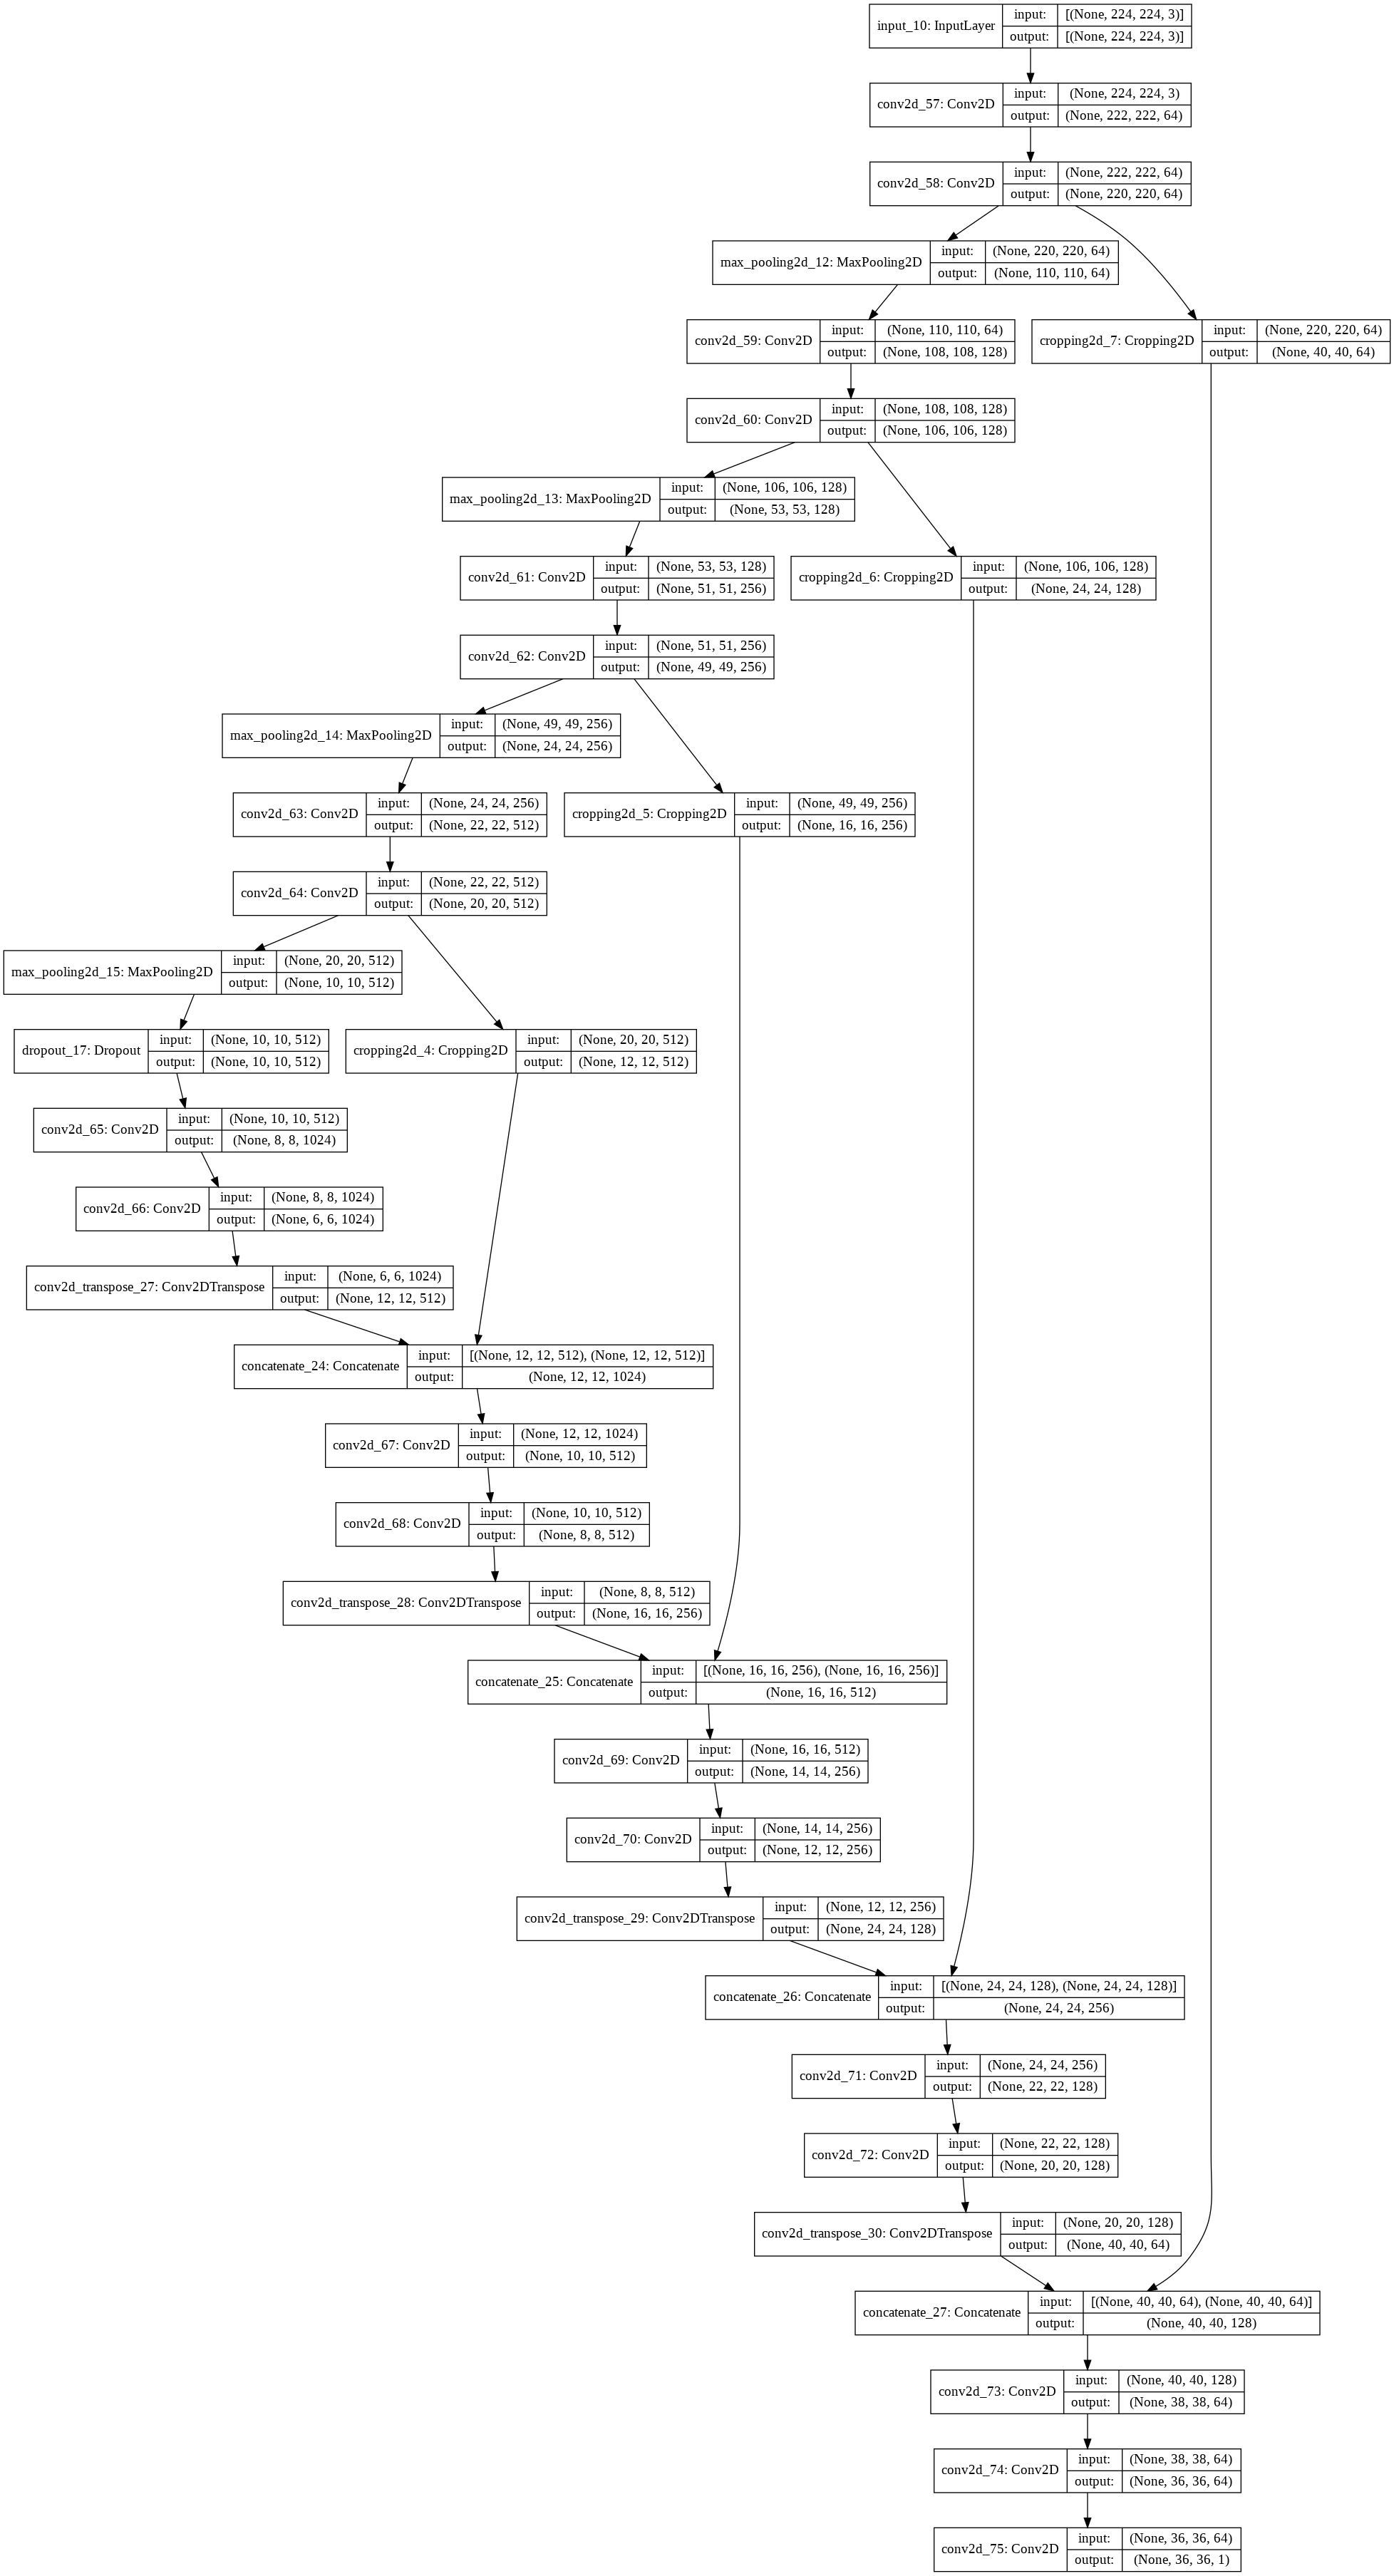

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 11
STEPS_PER_EPOCH = 57

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Epoch 1/20


ValueError: ignored

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
def imDisplay(im1, im2 = None, im3 = None):
  plt.figure()


  if im2 is not None and im3 is not None:

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(1,3) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0].imshow(im1, vmin=0, vmax=1)
    axarr[1].imshow(im2, vmin=0, vmax=1)
    axarr[2].imshow(im3)
  elif im2 is not None and im3 is None:

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(1,2) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0].imshow(im1, vmin=0, vmax=1)
    axarr[1].imshow(im2, vmin=0, vmax=1)
  
  else:
    imshow(im1)


<Figure size 432x288 with 0 Axes>

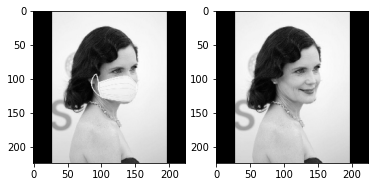

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
imDisplay(sample_image, sample_mask)
#sample_image.shape

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      imDisplay([image[0], mask[0], create_mask(pred_mask)])
  else:
    res = [sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))]
    #print(res[2])
    imDisplay(res[0][:,:,0], res[1][:,:,0], res[2][:,:,0])

<Figure size 432x288 with 0 Axes>

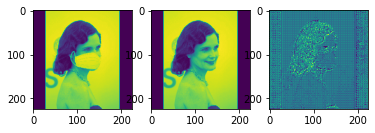

In [ ]:
show_predictions()
#max(a[2])
#imDisplay(a[0], a[1], a[2][:,:,0])

In [ ]:
np.max(a[2])

0

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 11
STEPS_PER_EPOCH = 57

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH
                          )

In [ ]:
layer_names

['block_0_expand_relu',
 'block_1_expand_relu',
 'block_3_expand_relu',
 'block_6_expand_relu',
 'block_13_expand_relu',
 'block_16_project']

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-1g4bu_1x
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-1g4bu_1x
  Created wheel for tensorflow-examples: filename=tensorflow_examples-794d221d2da439873c9adfeb6bd1401946112e94_-cp37-none-any.whl size=265246 sha256=3df92967cab026cc194582176648414ddc2159946d8f1c622a870303f321c9b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-bsm3it7r/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMSIZE, IMSIZE, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

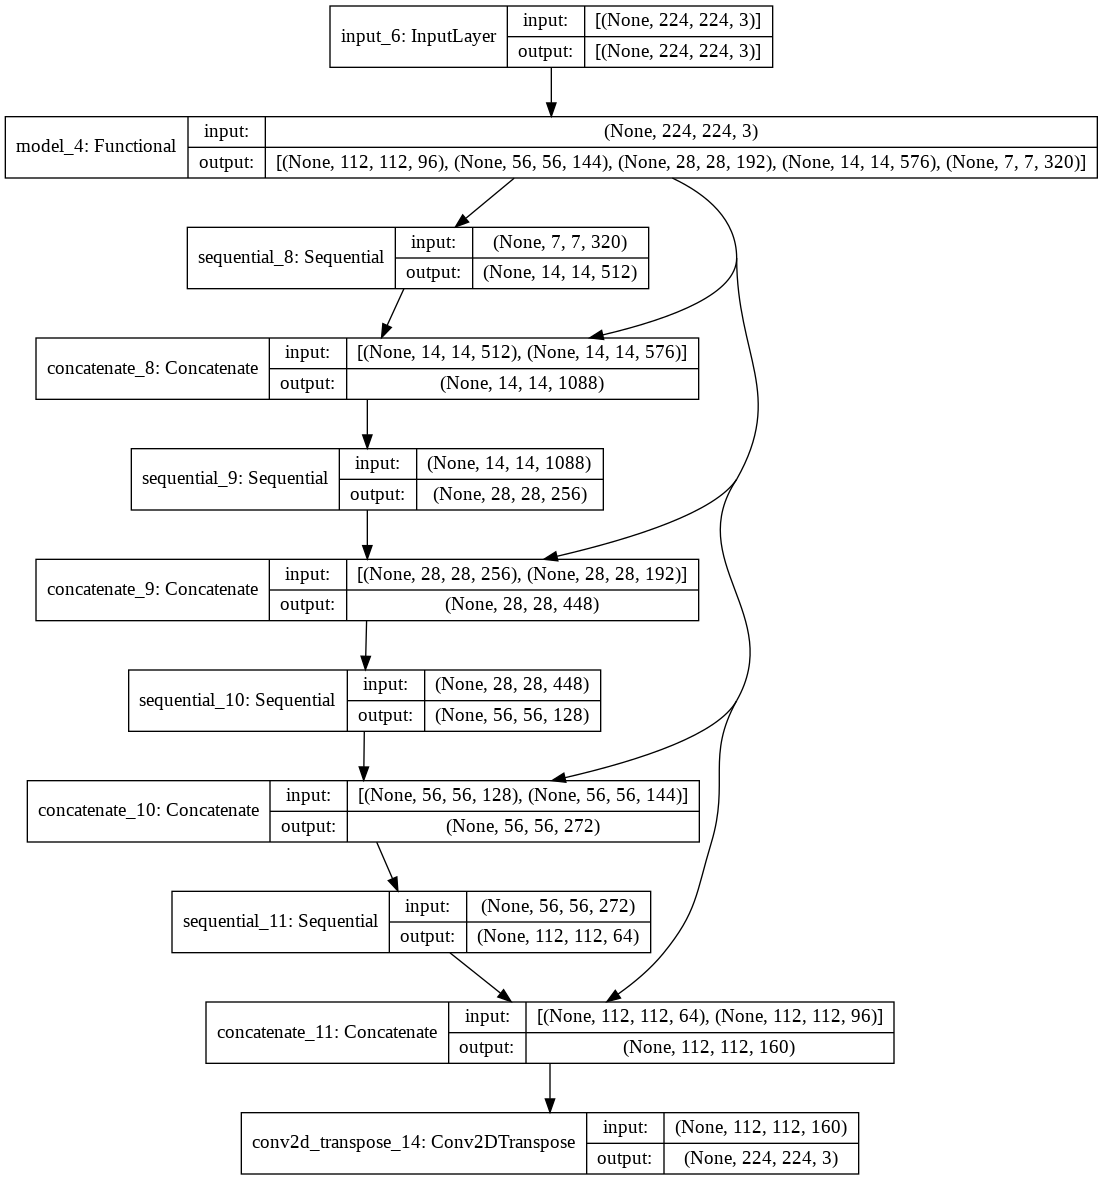

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = modl.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    return([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

<Figure size 432x288 with 0 Axes>

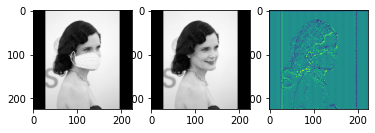

In [ ]:
a = show_predictions()
#max(a[2])
#imDisplay(a[0], a[1], a[2][,:])
from google.colab.patches import cv2_imshow
imDisplay(a[0], a[1], a[2][:,:,0])
imshow(a[2][:,:,0])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 3)), types: (tf.float32, tf.float32)>

Epoch 1/20
57/57 [==============================] - 20s 356ms/step - loss: 1.2152 - accuracy: 0.3510

Sample Prediction after epoch 1

Epoch 2/20
57/57 [==============================] - 20s 358ms/step - loss: 1.2172 - accuracy: 0.3472

Sample Prediction after epoch 2

Epoch 3/20
57/57 [==============================] - 20s 355ms/step - loss: 1.2212 - accuracy: 0.3450

Sample Prediction after epoch 3

Epoch 4/20
57/57 [==============================] - 20s 353ms/step - loss: 1.2213 - accuracy: 0.3381

Sample Prediction after epoch 4

Epoch 5/20
57/57 [==============================] - 20s 354ms/step - loss: 1.2220 - accuracy: 0.3292

Sample Prediction after epoch 5

Epoch 6/20
57/57 [==============================] - 20s 354ms/step - loss: 1.2228 - accuracy: 0.3319

Sample Prediction after epoch 6

Epoch 7/20
57/57 [==============================] - 20s 355ms/step - loss: 1.2217 - accuracy: 0.3339

Sample Prediction after epoch 7

Epoch 8/20
57/57 [==============================] - 20s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


57/57 [==============================] - 20s 354ms/step - loss: 1.2208 - accuracy: 0.3414

Sample Prediction after epoch 12

Epoch 13/20
57/57 [==============================] - 20s 350ms/step - loss: 1.2188 - accuracy: 0.3390

Sample Prediction after epoch 13

Epoch 14/20
57/57 [==============================] - 20s 353ms/step - loss: 1.2238 - accuracy: 0.3261

Sample Prediction after epoch 14

Epoch 15/20
57/57 [==============================] - 20s 352ms/step - loss: 1.2181 - accuracy: 0.3311

Sample Prediction after epoch 15

Epoch 16/20
57/57 [==============================] - 20s 351ms/step - loss: 1.2240 - accuracy: 0.3476

Sample Prediction after epoch 16

Epoch 17/20
57/57 [==============================] - 20s 354ms/step - loss: 1.2227 - accuracy: 0.3547

Sample Prediction after epoch 17

Epoch 18/20
57/57 [==============================] - 20s 350ms/step - loss: 1.2227 - accuracy: 0.3543

Sample Prediction after epoch 18

Epoch 19/20
57/57 [==============================] - 

<Figure size 432x288 with 0 Axes>

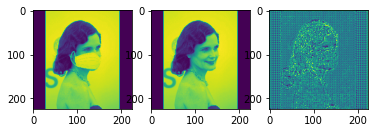

<Figure size 432x288 with 0 Axes>

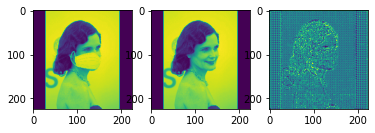

<Figure size 432x288 with 0 Axes>

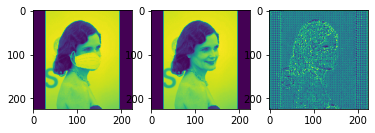

<Figure size 432x288 with 0 Axes>

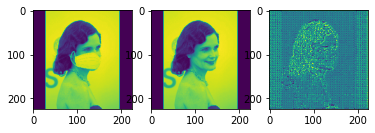

<Figure size 432x288 with 0 Axes>

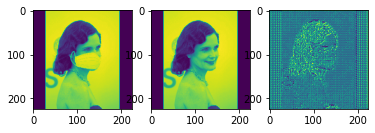

<Figure size 432x288 with 0 Axes>

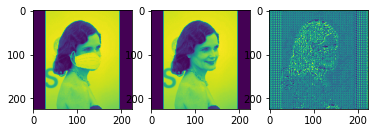

<Figure size 432x288 with 0 Axes>

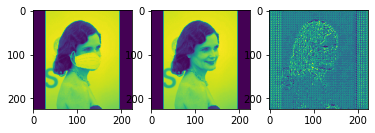

<Figure size 432x288 with 0 Axes>

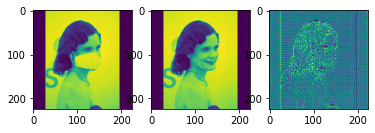

<Figure size 432x288 with 0 Axes>

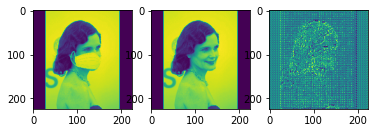

<Figure size 432x288 with 0 Axes>

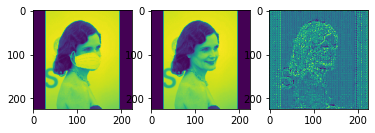

<Figure size 432x288 with 0 Axes>

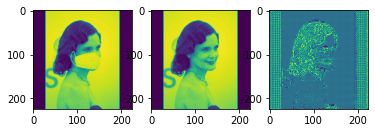

<Figure size 432x288 with 0 Axes>

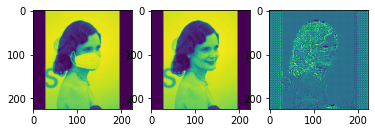

<Figure size 432x288 with 0 Axes>

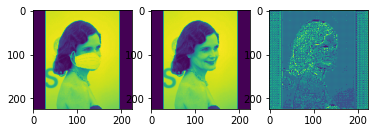

<Figure size 432x288 with 0 Axes>

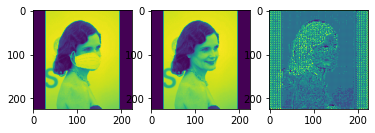

<Figure size 432x288 with 0 Axes>

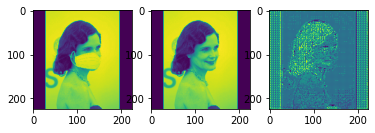

<Figure size 432x288 with 0 Axes>

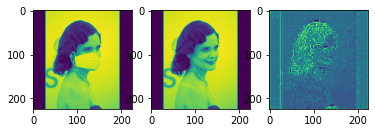

<Figure size 432x288 with 0 Axes>

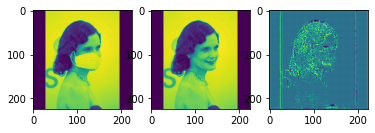

<Figure size 432x288 with 0 Axes>

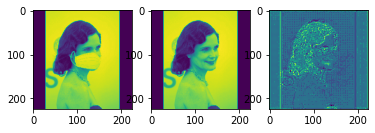

<Figure size 432x288 with 0 Axes>

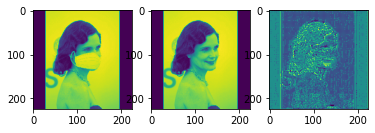

<Figure size 432x288 with 0 Axes>

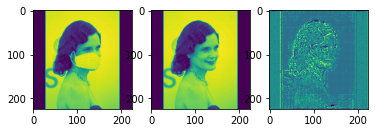

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 11
STEPS_PER_EPOCH = 57

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

NameError: ignored